In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader2, Dataset

import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.metrics import classification_report , confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm


In [2]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=64, width=64),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=64, width=64),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
batch_size = 128

In [4]:
import glob
import random
from pandas.core.common import flatten
train_data_path = 'Datasets/Rice_Image_Dataset/' 
# test_data_path = 'Datasets/xray_dataset_covid19/test' 

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train test from train paths (80,20)
train_image_paths, test_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 



# print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))
print("Train size: {}\nTest size: {}".format(len(train_image_paths),len(test_image_paths)))


train_image_path example:  Datasets/Rice_Image_Dataset/Arborio/Arborio (10375).jpg
class example:  Karacadag
Train size: 60000
Test size: 15000


In [5]:
train_image_paths

['Datasets/Rice_Image_Dataset/Arborio/Arborio (10375).jpg',
 'Datasets/Rice_Image_Dataset/Jasmine/Jasmine (6328).jpg',
 'Datasets/Rice_Image_Dataset/Arborio/Arborio (14601).jpg',
 'Datasets/Rice_Image_Dataset/Jasmine/Jasmine (13657).jpg',
 'Datasets/Rice_Image_Dataset/Arborio/Arborio (1330).jpg',
 'Datasets/Rice_Image_Dataset/Ipsala/Ipsala (13491).jpg',
 'Datasets/Rice_Image_Dataset/Jasmine/Jasmine (13156).jpg',
 'Datasets/Rice_Image_Dataset/Ipsala/Ipsala (12843).jpg',
 'Datasets/Rice_Image_Dataset/Arborio/Arborio (10773).jpg',
 'Datasets/Rice_Image_Dataset/Karacadag/Karacadag (1732).jpg',
 'Datasets/Rice_Image_Dataset/Arborio/Arborio (13706).jpg',
 'Datasets/Rice_Image_Dataset/Arborio/Arborio (7059).jpg',
 'Datasets/Rice_Image_Dataset/Arborio/Arborio (3849).jpg',
 'Datasets/Rice_Image_Dataset/Ipsala/Ipsala (11716).jpg',
 'Datasets/Rice_Image_Dataset/Karacadag/Karacadag (585).jpg',
 'Datasets/Rice_Image_Dataset/Jasmine/Jasmine (882).jpg',
 'Datasets/Rice_Image_Dataset/Ipsala/Ipsala (67

In [6]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}


In [7]:
class XRayDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
#         self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        
#             image = A.resize(image,3,64,64) #(image=image)["image"]
        image = torch.tensor(image)
        
        image = image.permute(2,0,1)
        Trans = torchvision.transforms.Resize((64,64))
        image = Trans(image)

        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = XRayDataset(train_image_paths)
# valid_dataset = XRayDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = XRayDataset(test_image_paths)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


['Karacadag', 'Ipsala', 'Arborio', 'Basmati', 'Jasmine']

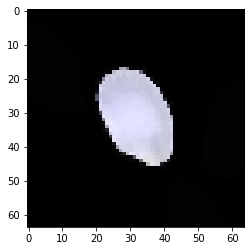

In [8]:
# img = plt.imread('tr.jpeg')
# ar = img.reshape(28,28)
# torch.tensor(img)
x = train_dataset[9][0]
print(x)
x= x.permute(1,2,0)

plt.imshow(x)
# train_dataset[0][0].numpy().shape
classes

In [9]:
def plot_loss(loss):
        '''
        Plots the loss curve
        '''
        fig = plt.figure(figsize=(10,10))
        plt.plot(loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show() 

In [10]:
train_loader = DataLoader2(train_dataset,batch_size=batch_size,shuffle=True) 
test_loader = DataLoader2(test_dataset,batch_size=batch_size,shuffle=True) 


In [11]:
def accuracy(train_loader,test_loader,model,reshape=True):
    model.eval()
    r_pred=[]
    r=[]
    for _,(x,y) in enumerate(train_loader):
        if reshape==True:
            x = x.reshape(x.shape[0],-1)
        scores = model(x)
        _, y_pred = scores.max(1)
        r = r + list(y.numpy())
        r_pred = r_pred + list(y_pred.numpy())
    
    print("\n\n########## Train Data Accuracy ######### \n\n")
    print(classification_report(r,r_pred))
    sns.heatmap(confusion_matrix(r,r_pred))
    plt.show()
    
    
    
    r_pred=[]
    r=[]
    for _,(x,y) in enumerate(test_loader):
        if reshape==True:
            x = x.reshape(x.shape[0],-1)
        scores = model(x)
        _, y_pred = scores.max(1)
        r = r + list(y.numpy())
        r_pred = r_pred + list(y_pred.numpy())
    
    print("\n\n########## Test Data Accuracy ######### \n\n") 
    print(classification_report(r,r_pred))
    sns.heatmap(confusion_matrix(r,r_pred))


In [12]:
######### CNN Example
class CNN(nn.Module):
    def __init__(self,in_channels=1,num_classes=10):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,16,kernel_size=(2,2),stride=(1,1),padding=(1,1))
        self.conv2 = nn.Conv2d(16,8,kernel_size=(2,2),stride=(1,1),padding=(1,1))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.fc1 = nn.Linear(8*16*16,32)        
        self.fc2 = nn.Linear(32,10)        
        self.fc3 = nn.Linear(10,num_classes)        
#         self.fc2 = nn.Linear(20,num_classes)pri
    def forward(self,x):
        x = x.type(dtype=torch.float32)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0],-1)
        x = F.relu(self.fc1(x))     
        x = F.relu(self.fc2(x))     
        x = self.fc3(x)   
#         x = self.fc2(x)       
#         x = self.fc2(x)
        return x

469it [01:09,  6.71it/s]


epoch 20/1  loss=0.11033167690038681 


469it [01:10,  6.61it/s]


epoch 20/2  loss=0.10311844199895859 


469it [01:10,  6.68it/s]


epoch 20/3  loss=0.03262733295559883 


469it [01:16,  6.12it/s]


epoch 20/4  loss=0.020801300182938576 


469it [01:06,  7.08it/s]


epoch 20/5  loss=0.00995709840208292 


469it [01:01,  7.62it/s]


epoch 20/6  loss=0.011682995595037937 


469it [01:00,  7.73it/s]


epoch 20/7  loss=0.00342566124163568 


469it [01:02,  7.47it/s]


epoch 20/8  loss=0.042047154158353806 


469it [01:02,  7.51it/s]


epoch 20/9  loss=0.008366758935153484 


469it [01:02,  7.52it/s]


epoch 20/10  loss=0.014878434129059315 


469it [01:08,  6.84it/s]


epoch 20/11  loss=0.06876527518033981 


469it [01:07,  6.92it/s]


epoch 20/12  loss=0.016734791919589043 


469it [01:08,  6.84it/s]


epoch 20/13  loss=0.010098698548972607 


469it [01:08,  6.81it/s]


epoch 20/14  loss=0.00973297655582428 


469it [01:09,  6.73it/s]


epoch 20/15  loss=0.0021450850181281567 


469it [01:09,  6.71it/s]


epoch 20/16  loss=0.014769061468541622 


469it [01:09,  6.70it/s]


epoch 20/17  loss=0.031878773123025894 


469it [01:09,  6.70it/s]


epoch 20/18  loss=0.0037761954590678215 


469it [01:11,  6.58it/s]


epoch 20/19  loss=0.0093941455706954 


469it [01:10,  6.67it/s]


epoch 20/20  loss=0.00460282014682889 


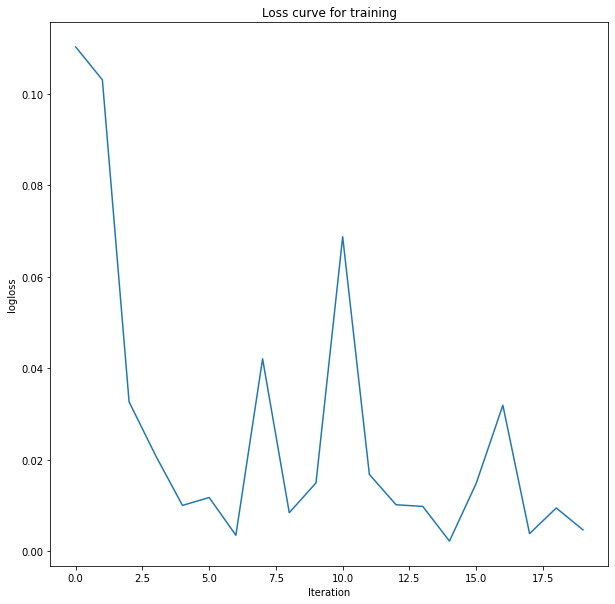

In [14]:
in_channels= 3
num_classes= 5
lr = 0.0001
epochs = 20

## Model Initialization
model_cnn = CNN(in_channels,num_classes)


## Loss Function and Optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(),lr=lr)


##### Train The network ##########
train_loss = []
for epoch in range(epochs):
    for batch_id,(x,y) in  tqdm(enumerate(train_loader),ncols=100):
        
#         x = x.reshape(x.shape[0],-1)
        
        scores = model_cnn(x)
        loss = loss_func(scores,y)
        
        # backward prop
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
    train_loss.append(loss.detach().numpy().sum())
    print('epoch {}/{}  loss={} '.format(epochs, epoch+1,loss))
plot_loss(train_loss)
    


        




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     12001
           1       1.00      1.00      1.00     12000
           2       0.99      1.00      0.99     12015
           3       1.00      0.99      1.00     12076
           4       0.99      1.00      1.00     11908

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



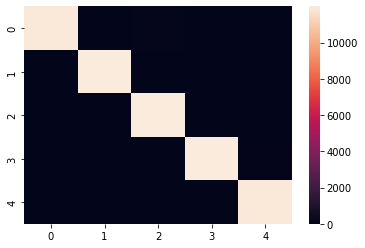



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2999
           1       1.00      1.00      1.00      3000
           2       0.98      1.00      0.99      2985
           3       1.00      0.99      0.99      2924
           4       0.99      0.99      0.99      3092

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



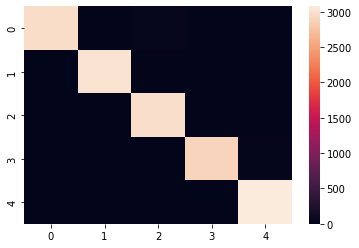

In [15]:
accuracy(train_loader,test_loader,model_cnn,reshape=False)